In [1]:
from google.colab import drive
import sys
drive.mount("/content/gdrive", force_remount=True)
sys.path.append('/content/gdrive/My Drive/THESIS')
!pip install tensorflow-addons

Mounted at /content/gdrive


In [2]:
from backend.preprocessing import *
from backend.metrics import *
from backend.gan import GAN
from backend.tcn import make_TCN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from tensorflow.random import normal

In [3]:
df = pd.read_csv('gdrive/My Drive/THESIS/datasets/sp500.csv').set_index('Date')
log_returns = np.log(df/df.shift(1))[1:].to_numpy()

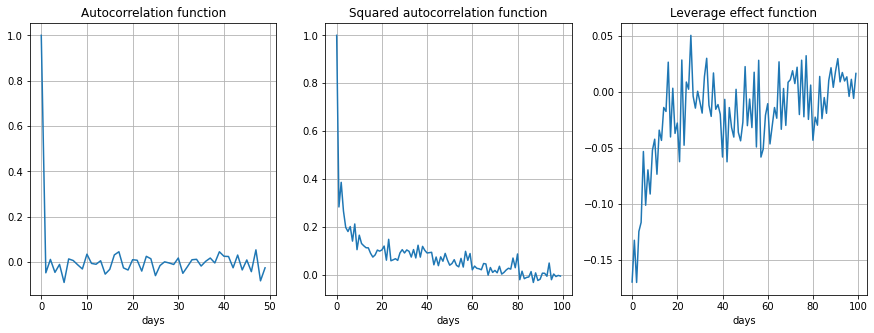

In [4]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].plot(acf(log_returns, 50))
axs[0].set_title('Autocorrelation function')
axs[1].plot(acf(log_returns**2, 100))
axs[1].set_title('Squared autocorrelation function')
axs[2].plot(acf(log_returns, 100, le=True))
axs[2].set_title('Leverage effect function')


for ax in axs: ax.grid(True)
plt.setp(axs, xlabel='days');

In [5]:
s1 = StandardScaler()
s2 = StandardScaler()
g1 = Gaussianize()

# receptive field size
rfs = 127

# pre-processing pipeline
log_returns_preprocessed = s2.fit_transform(g1.fit_transform(s1.fit_transform(log_returns)))
log_returns_rolled = rolling_window(log_returns_preprocessed, rfs)

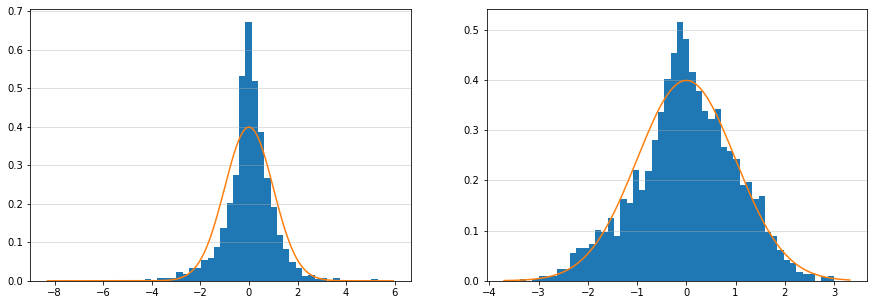

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
# We plot the distribution of log returns before and after the
# lambert W inverse transform respectively (both standardized). 
# We overlay it with a standard normal.

ax[0].hist(s1.transform(log_returns), bins=50, density=True)
x_range = np.linspace(*ax[0].get_xlim(), num=1000)
ax[0].plot(x_range, norm.pdf(x_range))

ax[1].hist(log_returns_preprocessed, bins=50, density=True)
x_range = np.linspace(*ax[1].get_xlim(), num=1000)
ax[1].plot(x_range, norm.pdf(x_range))

# add a grid to compare easily
ax[0].yaxis.grid(True, alpha=0.5)
ax[1].yaxis.grid(True, alpha=0.5);

In [7]:
dilations = 2**(np.arange(6))
n_filters = 80

discriminator = make_TCN(dilations, n_filters, False, False, [1, rfs, 1])
generator = make_TCN(dilations, n_filters, True, False, [1, None, 3])

In [8]:
class verboseGAN(GAN):
    def train_hook(self, n_batch):
        if (n_batch + 1) % 500 == 0:
            y = self.generator(self.fixed_noise).numpy().squeeze()
            scores = []
            scores.append(np.linalg.norm(self.acf_real - acf(y.T, 250).mean(axis=1, keepdims=True)))
            scores.append(np.linalg.norm(self.abs_acf_real - acf(y.T**2, 250).mean(axis=1, keepdims=True)))
            scores.append(np.linalg.norm(self.le_real - acf(y.T, 250, le=True).mean(axis=1, keepdims=True)))
            print("\nacf: {:.4f}, acf_abs: {:.4f}, le: {:.4f}".format(*scores))
        
gan = verboseGAN(discriminator, generator, lr_d=1e-4, lr_g=3e-5)

gan.acf_real = acf(log_returns_preprocessed, 250)
gan.abs_acf_real = acf(log_returns_preprocessed**2, 250)
gan.le_real = acf(log_returns_preprocessed, 250, le=True)

gan.fixed_noise = normal([128, 1, 4000 + rfs - 1, 3])

In [9]:
data = np.expand_dims(np.moveaxis(log_returns_rolled, 0,1), 1)
batch_size = 64
n_batches = 5000
additional_d_steps = 0

gan.train(data, batch_size, n_batches, additional_d_steps)

 499/5000 [=>............................] - ETA: 9:58
acf: 0.3975, acf_abs: 1.1399, le: 0.5735
 999/5000 [====>.........................] - ETA: 9:26
acf: 0.3788, acf_abs: 1.0506, le: 0.3896
1499/5000 [=======>......................] - ETA: 8:26
acf: 0.3788, acf_abs: 0.9339, le: 0.3836
1999/5000 [==========>...................] - ETA: 7:17
acf: 0.3737, acf_abs: 0.8353, le: 0.3938
2499/5000 [=============>................] - ETA: 6:07
acf: 0.3688, acf_abs: 0.7040, le: 0.4167
2999/5000 [================>.............] - ETA: 4:54
acf: 0.3566, acf_abs: 0.5920, le: 0.3734
3499/5000 [===================>..........] - ETA: 3:41
acf: 0.3592, acf_abs: 0.4867, le: 0.3930
3999/5000 [======================>.......] - ETA: 2:28
acf: 0.3672, acf_abs: 0.5234, le: 0.3637
4499/5000 [=========================>....] - ETA: 1:14
acf: 0.3638, acf_abs: 0.5475, le: 0.3593
4999/5000 [============================>.] - ETA: 0s
acf: 0.3490, acf_abs: 0.4916, le: 0.3880
5000/5000 [==============================]

In [10]:
gan.save('/content/gdrive/My Drive/THESIS/trained_generator')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/THESIS/trained_generator/assets


In [11]:
noise = normal([50, 1, len(log_returns_preprocessed) + rfs - 1, 3])
y = generator(noise).numpy().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = s2.inverse_transform(y)
y = np.array([g1.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = s1.inverse_transform(y)

# some basic filtering, GAN has the tendency to produce extreme returns, caused by
# a tendency of the generator to produce heavier than normal tails, which is exercerbated
# by the lambert W transform. We filter out returns with more than twice the extremas of the
# original distribution.
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]

# center the log_paths for the picture
y -= y.mean()

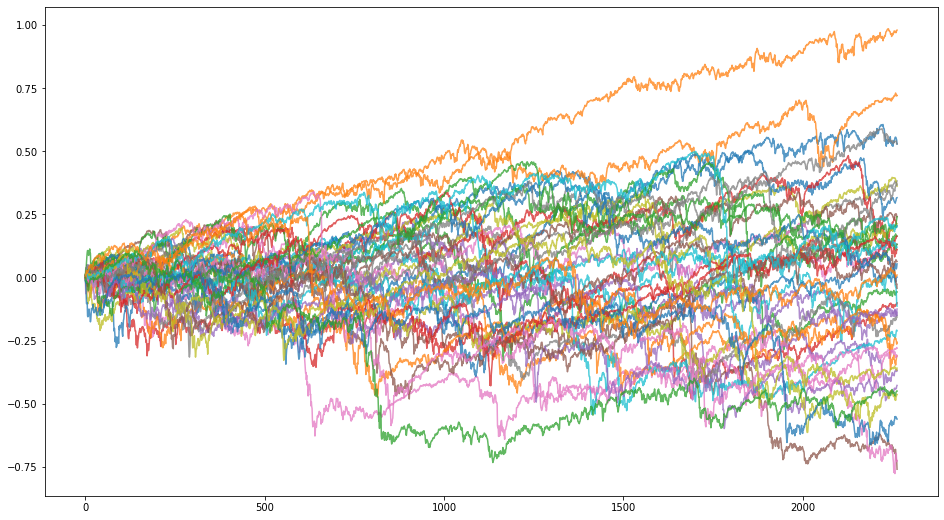

In [12]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(np.cumsum(y, axis=1).T, alpha=0.75);

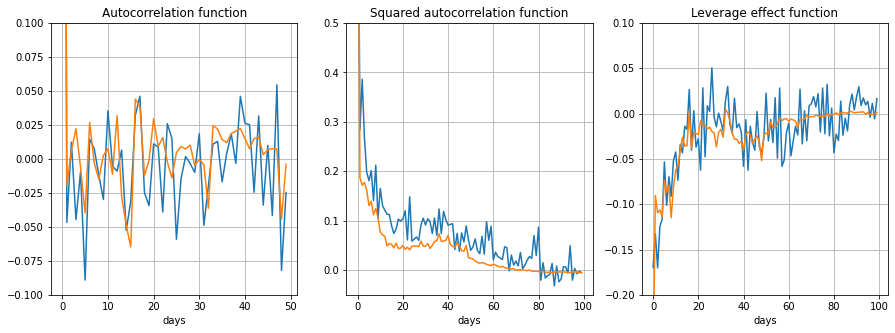

In [13]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].plot(acf(log_returns, 50))
axs[0].plot(acf(y.T, 50).mean(axis=1))
axs[0].set_ylim(-0.1, 0.1)
axs[0].set_title('Autocorrelation function')
axs[1].plot(acf(log_returns**2, 100))
axs[1].set_ylim(-0.05, 0.5)
axs[1].plot(acf(y.T**2, 100).mean(axis=1))
axs[1].set_title('Squared autocorrelation function')
axs[2].plot(acf(log_returns, 100, le=True))
axs[2].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[2].set_ylim(-0.2, 0.1)
axs[2].set_title('Leverage effect function')


for ax in axs: ax.grid(True)
plt.setp(axs, xlabel='days');